In [10]:
#https://scvi.readthedocs.io/en/master/_modules/scvi/inference/trainer.html
# https://dziganto.github.io/classes/data%20science/linear%20regression/machine%20learning/object-oriented%20programming/python/Understanding-Object-Oriented-Programming-Through-Machine-Learning/

In [11]:
import numpy as np

## Defining the generic metrics class

In [3]:
class ModifiedMetrics:
    # Where k∗ is the numbers of parameters you're estimating INCLUDING an intercept. 
    #(The residual vector will exist in an n−k∗ dimensional linear space.)

    # If you include an intercept term in a regression and k refers to the number of regressors
    # not including the intercept then k∗=k+1.
    
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.predict(self.data)) ** 2
        self.sq_error_ = np.sum(squared_errors)
        return self.sq_error_
        
    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        self.sst_ = np.sum(squared_errors)
        return self.sst_
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        self.r_sq_ = 1 - self.sse()/self.sst()
        return self.r_sq_
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        self.adj_r_sq_ = 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
        return self.adj_r_sq_
    
    def rmse(self):
        '''returns calculated value of mse'''
        self.rmse_ = np.sqrt(np.mean( (self.predict(self.data) - self.target) ** 2 ))
        return self.rmse_
    
    def pretty_print_stats(self):
        '''returns report of statistics for a given model object'''
        items = ( ('rmse:', self.rmse()), ('r^2:', self.r_squared()), 
                  ('adj_r^2:', self.adj_r_squared()))
        for item in items:
            print('{0:8} {1:.4f}'.format(item[0], item[1]))


## Defining the Linear Regression Class

In [4]:
# only makes sense for Linear Regression https://stats.stackexchange.com/questions/23128/solving-for-regression-parameters-in-closed-form-vs-gradient-descent
class LinearRegression(ModifiedMetrics):
    
    def __init__(self, fit_intercept=True):
        self.coef_ = None
        self.intercept_ = None
        self._fit_intercept = fit_intercept
          
        
    def fit(self, X, y):
        """
        Fit model coefficients.

        Arguments:
        X: 1D or 2D numpy array 
        y: 1D numpy array
        """
         #degrees of freedom population dep. variable variance -- this is total amount of degrees
        self._dft = X.shape[0] - 1   
        # degrees of freedom for the residuals
        self._dfe = X.shape[0] - X.shape[1] - 1  # the more independent variables, the less adj_R-sq
        
        # training data & ground truth data
        self.data = X
        self.target = y
                
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)
            
        # add bias if fit_intercept
        if self._fit_intercept:
            X = np.c_[np.ones(X.shape[0]), X]
        
        # closed form solution
        xTx = np.dot(X.T, X)
        inverse_xTx = np.linalg.inv(xTx)
        xTy = np.dot(X.T, y)
        coef = np.dot(inverse_xTx, xTy)
        
        # set attributes
        if self._fit_intercept:
            self.intercept_ = coef[0]
            self.coef_ = coef[1:]
        else:
            self.intercept_ = 0
            self.coef_ = coef
            
    def predict(self, X):
        """Output model prediction.

        Arguments:
        X: 1D or 2D numpy array 
        """
        # check if X is 1D or 2D array
        if len(X.shape) == 1:
            X = X.reshape(-1,1)  # force 1D array into a column vector
        return self.intercept_ + np.dot(X, self.coef_)
    
    def __str__(self):
        return "Results: b: {}, m: {}, Final Total error: {}".format(round(self.b, 2), round(self.m, 2), round(self.compute_error(), 2))

## The Problem : Housing Price Prediction

In [5]:
from sklearn.datasets import load_boston
import pandas as pd
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['MEDV'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### What is in the Dataset?

In [15]:
print(boston_dataset.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [16]:
boston.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

### Visualizing  The Dependent Variable

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(boston['MEDV'], bins=30)
plt.show()

<Figure size 1170x827 with 1 Axes>

## Selecting Features Based on Correlation

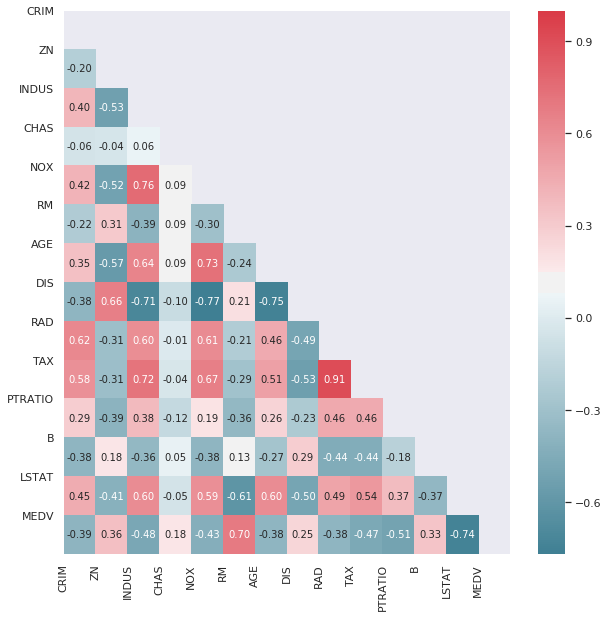

In [15]:
def doCorrelationReduction(corr_matrix = boston.corr(), original_data = boston, corr_thr=0.45):
    import numpy as np
    corr_matrix_abs = corr_matrix.abs()
    upper = corr_matrix_abs.where(
        np.triu(np.ones(corr_matrix_abs.shape), k=1).astype(np.bool))  # # Select upper triangle of correlation matrix
    # # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > corr_thr)]
    low_cor_data = original_data[pd.DataFrame(original_data).columns.difference(to_drop)]

    return (low_cor_data)

def heatMap(df, mirror=False):

   # Create Correlation df
   corr = df.corr()
   # Plot figsize
   fig, ax = plt.subplots(figsize=(10, 10))
   # Generate Color Map
   colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
   if mirror == True:
      #Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
      #Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      #Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
      #show plot

   else:
      # Drop self-correlations
      dropSelf = np.zeros_like(corr)
      dropSelf[np.triu_indices_from(dropSelf)] = True
      # Generate Color Map
      colormap = sns.diverging_palette(220, 10, as_cmap=True)
      # Generate Heat Map, allow annotations and place floats in map
      sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf)
      # Apply xticks
      plt.xticks(range(len(corr.columns)), corr.columns);
      # Apply yticks
      plt.yticks(range(len(corr.columns)), corr.columns)
   # show plot
   plt.show()
    
heatMap(df=boston)
boston_corr_reduced = doCorrelationReduction()

### Notice Any Dimensionality Reduction?

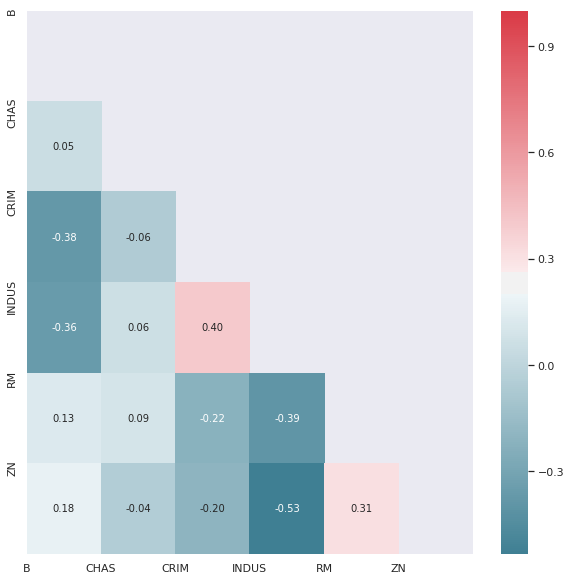

In [16]:
heatMap(df=boston_corr_reduced)

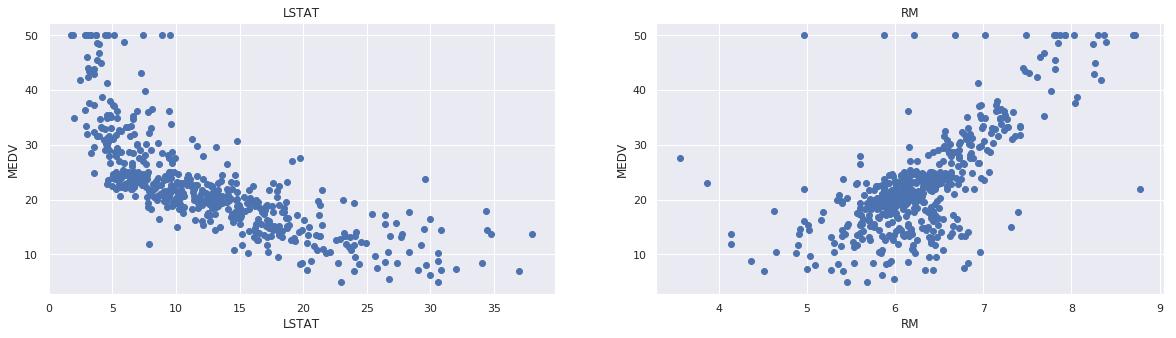

In [20]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = boston['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = boston[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

## Preparing Data for Machine Learning

In [21]:
X = pd.DataFrame(np.c_[boston['LSTAT'], boston['RM']], columns = ['LSTAT','RM'])
Y = boston['MEDV']
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


In [6]:
# importlib.reload(mymodule), # https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
metrics = ModifiedMetrics()
linreg_model = LinearRegression(metrics)
linreg_model.__dict__
linreg_model.fit(X=X_train,y=Y_train)
linreg_model.pretty_print_stats()

TypeError: __init__() missing 3 required positional arguments: 'X', 'y', and 'model'

In [ ]:
import inspect
lines = inspect.getsource(linreg_model.pretty_print_stats)
print(lines)

## To Implement : 

### make sure if you add features that you transform both train and test

### Comparison Results with Pytorch and SkLearn Linear Regression, Use Bayesian Feature Selection or Lasso to Select the best performing feature
### Try Also polynomial features 

### Analysis of results with Statsmodels

### Implement __str__ or repr method to the Linear Regression class

### ALWAYS BBEFORE DOING LINEAR REGRESSION, CHECK IF ASSUMPTIONS HOLD

You can implement linear regression in Python relatively easily by using the package statsmodels as well. Typically, this is desirable when there is a need for more detailed results.

In [27]:
import statsmodels.api as sm
X_constant_added = sm.add_constant(x=X)
model = sm.OLS(y, x=X_constant_added)
results_statsmodel = model.fit()
print(results.summary())
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params)

/home/alaridl/anaconda3/envs/python_for_ml/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
## predicted response
print('predicted response:', results.fittedvalues, sep='\n')
print('predicted response:', results.predict(x), sep='\n')


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

linreg_model_sklearn = LinearRegression().fit(x=X, y=Y)
transformer = PolynomialFeatures(degree=2, include_bias=False)
X_with_polynomial =  transformer.transform(x=X)



In [ ]:
## Comparison of Predictions
y_pred_own = linreg_model.predict(X=X_test)
y_pred_sklearn = linreg_model_sklearn.predict(x=X_test)
